In [12]:
!pip install pandas

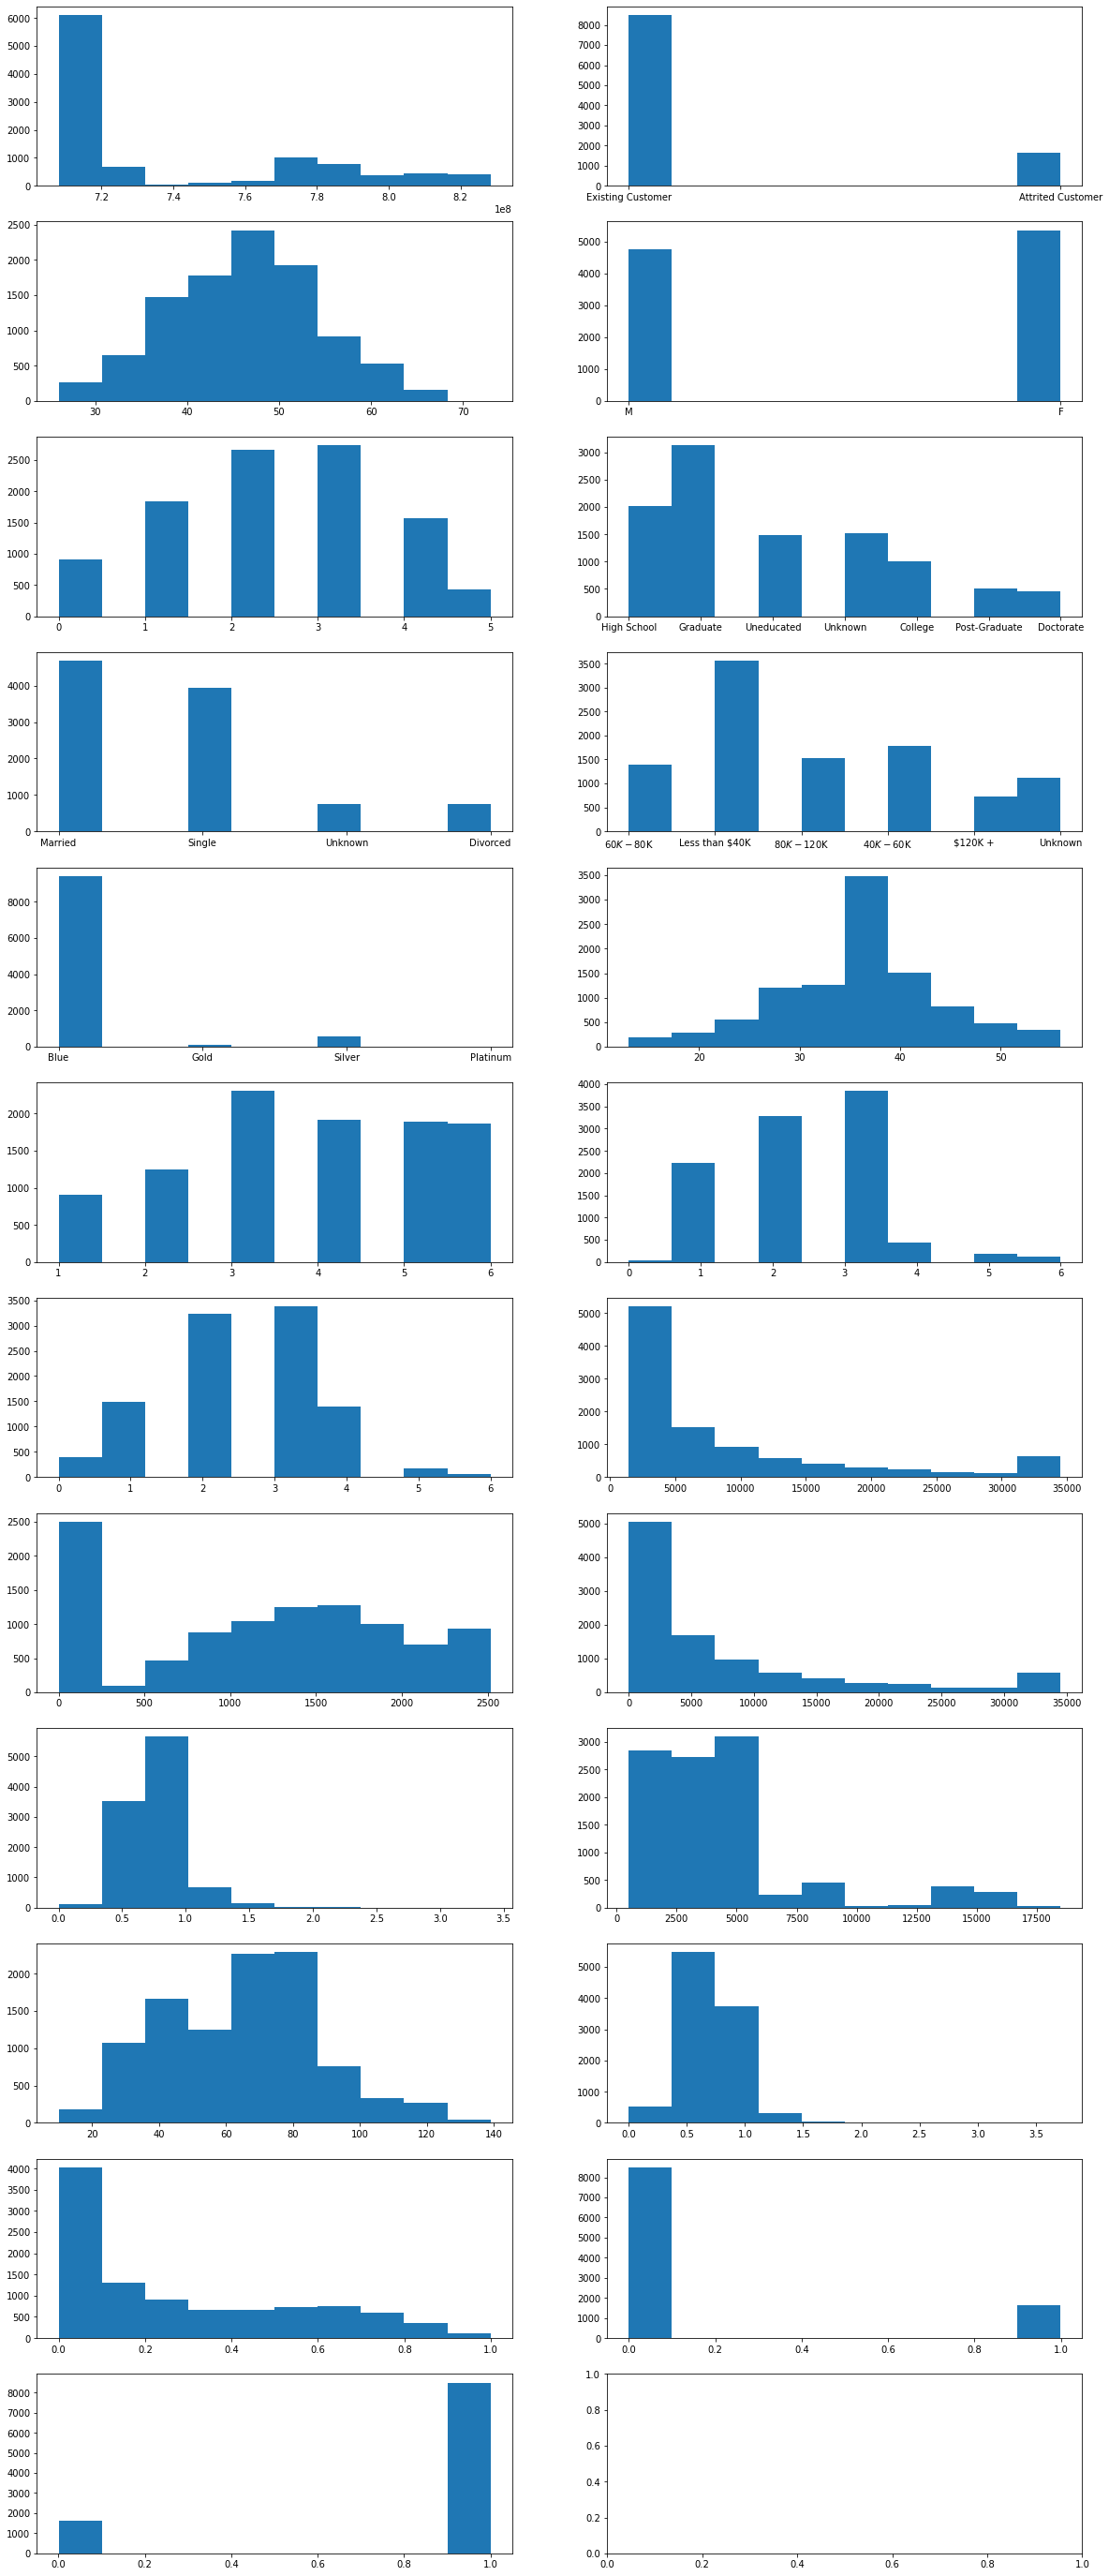

In [4]:
!pip install seaborn

  Using cached seaborn-0.11.1-py3-none-any.whl (285 kB)


In [8]:
!pip install numpy

In [10]:
!pip install scikit-learn

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import neighbors, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


data = pd.read_csv("BankChurners.csv")

# data["Attrition_Flag"] = data["Attrition_Flag"].map({"Attrited Customer": 0,
#                                                      "Existing Customer": 1})
Le = LabelEncoder()
data["Attrition_Flag"] = Le.fit_transform(data["Attrition_Flag"].values)

In [4]:
data

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,1,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.999910
1,818770008,1,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.999940
2,713982108,1,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.999980
3,769911858,1,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.999870
4,709106358,1,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.999980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,1,50,M,2,Graduate,Single,$40K - $60K,Blue,40,...,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462,0.000191,0.999810
10123,710638233,0,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,...,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511,0.995270,0.004729
10124,716506083,0,44,F,1,High School,Married,Less than $40K,Blue,36,...,5409.0,0,5409.0,0.819,10291,60,0.818,0.000,0.997880,0.002118
10125,717406983,0,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,...,5281.0,0,5281.0,0.535,8395,62,0.722,0.000,0.996710,0.003294


In [73]:
def get_unique(x: np.ndarray, y: np.ndarray):
    x_set = np.array([x[0, :], ])
    y_set = np.array([y[0]])
    for i in range(len(x)):
        for j in range(len(x_set)):
            if all(x_set[j, :] == x[i, :]):
                break
        else:
            x_set = np.vstack((x_set, x[i, :]))
            y_set = np.vstack((y_set, y[i]))
    return x_set, y_set

def analyze_data(dataset: pd.core.frame.DataFrame, target_name: str,
                 max_diff: float):
    target_data_arr = dataset[target_name].values
    dataset = dataset.drop([target_name], axis=1)
    trash_features = []
    for feature_name in dataset.keys():
        feature_data = dataset[feature_name]
        feature_data_dict = dict() # feature_data_dict =
        # {<feature_i-data>:  {
        #                     "count": <numb of same feature_i-data>,
        #                     "pos_target": <numb of positive target for objects with this feature_i-data>,
        #                     "neg_target": <numb of negative target for objects with this feature_i-data>
        #                     }
        # }

        for idx, feat_i in enumerate(feature_data):
            if feature_data_dict.get(feat_i, None) is None:
                feature_data_dict[feat_i] = {"count": 1, "pos_target": 0, "neg_target": 0}
            else:
                feature_data_dict[feat_i]["count"] += 1

            if target_data_arr[idx] == 0:
                feature_data_dict[feat_i]["neg_target"] += 1
            else:
                feature_data_dict[feat_i]["pos_target"] += 1

        print(f"\n{feature_name} pos/neg target ratio:")
        feature_i_ratio = []
        for i in feature_data_dict.items():
            pos = i[1]['pos_target'] # number of positive target for objects with this feature_i-data
            neg = i[1]['neg_target'] # number of negative target for objects with this feature_i-data
            if (neg == 0 or pos == 0):
                info_str = f"{feature_name} : {i[0]} ,ratio = {pos} / {neg}"
            else:
                info_str = f"{feature_name} : {i[0]} ,ratio = {pos} / {neg} = {round(pos / neg, 3)} " \
                           f"\tpos_perc = {round(100 * pos / (pos + neg), 2)}%, " \
                           f"neg_perc = {round(100 * neg / (pos + neg), 2)}%"
                feature_i_ratio.append(pos / neg)
            print(info_str)
        if (max(feature_i_ratio) - min(feature_i_ratio) < max_diff):
            trash_features.append(feature_name)
    return trash_features


In [2]:
!pip install matplotlib

  Using cached kiwisolver-1.3.1-cp38-cp38-win_amd64.whl (51 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)


In [75]:
data.keys()

Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
      dtype='object')

# dataset preparing

In [74]:
drop_features = [
    "CLIENTNUM",
    "Credit_Limit", "Total_Revolving_Bal",
    "Avg_Open_To_Buy", "Total_Amt_Chng_Q4_Q1",
    "Total_Trans_Amt", "Total_Ct_Chng_Q4_Q1",
    "Avg_Utilization_Ratio",
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1",
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2"
]
analyze_data(dataset=data.drop(drop_features, axis=1), target_name="Attrition_Flag",
             max_diff=1.5)



Customer_Age pos/neg target ratio:
Customer_Age : 45 ,ratio = 407 / 79 = 5.152 	pos_perc = 83.74%, neg_perc = 16.26%
Customer_Age : 49 ,ratio = 416 / 79 = 5.266 	pos_perc = 84.04%, neg_perc = 15.96%
Customer_Age : 51 ,ratio = 340 / 58 = 5.862 	pos_perc = 85.43%, neg_perc = 14.57%
Customer_Age : 40 ,ratio = 297 / 64 = 4.641 	pos_perc = 82.27%, neg_perc = 17.73%
Customer_Age : 44 ,ratio = 416 / 84 = 4.952 	pos_perc = 83.2%, neg_perc = 16.8%
Customer_Age : 32 ,ratio = 89 / 17 = 5.235 	pos_perc = 83.96%, neg_perc = 16.04%
Customer_Age : 37 ,ratio = 223 / 37 = 6.027 	pos_perc = 85.77%, neg_perc = 14.23%
Customer_Age : 48 ,ratio = 387 / 85 = 4.553 	pos_perc = 81.99%, neg_perc = 18.01%
Customer_Age : 42 ,ratio = 364 / 62 = 5.871 	pos_perc = 85.45%, neg_perc = 14.55%
Customer_Age : 65 ,ratio = 92 / 9 = 10.222 	pos_perc = 91.09%, neg_perc = 8.91%
Customer_Age : 56 ,ratio = 219 / 43 = 5.093 	pos_perc = 83.59%, neg_perc = 16.41%
Customer_Age : 35 ,ratio = 163 / 21 = 7.762 	pos_perc = 88.59%, neg

['Gender', 'Dependent_count', 'Marital_Status']

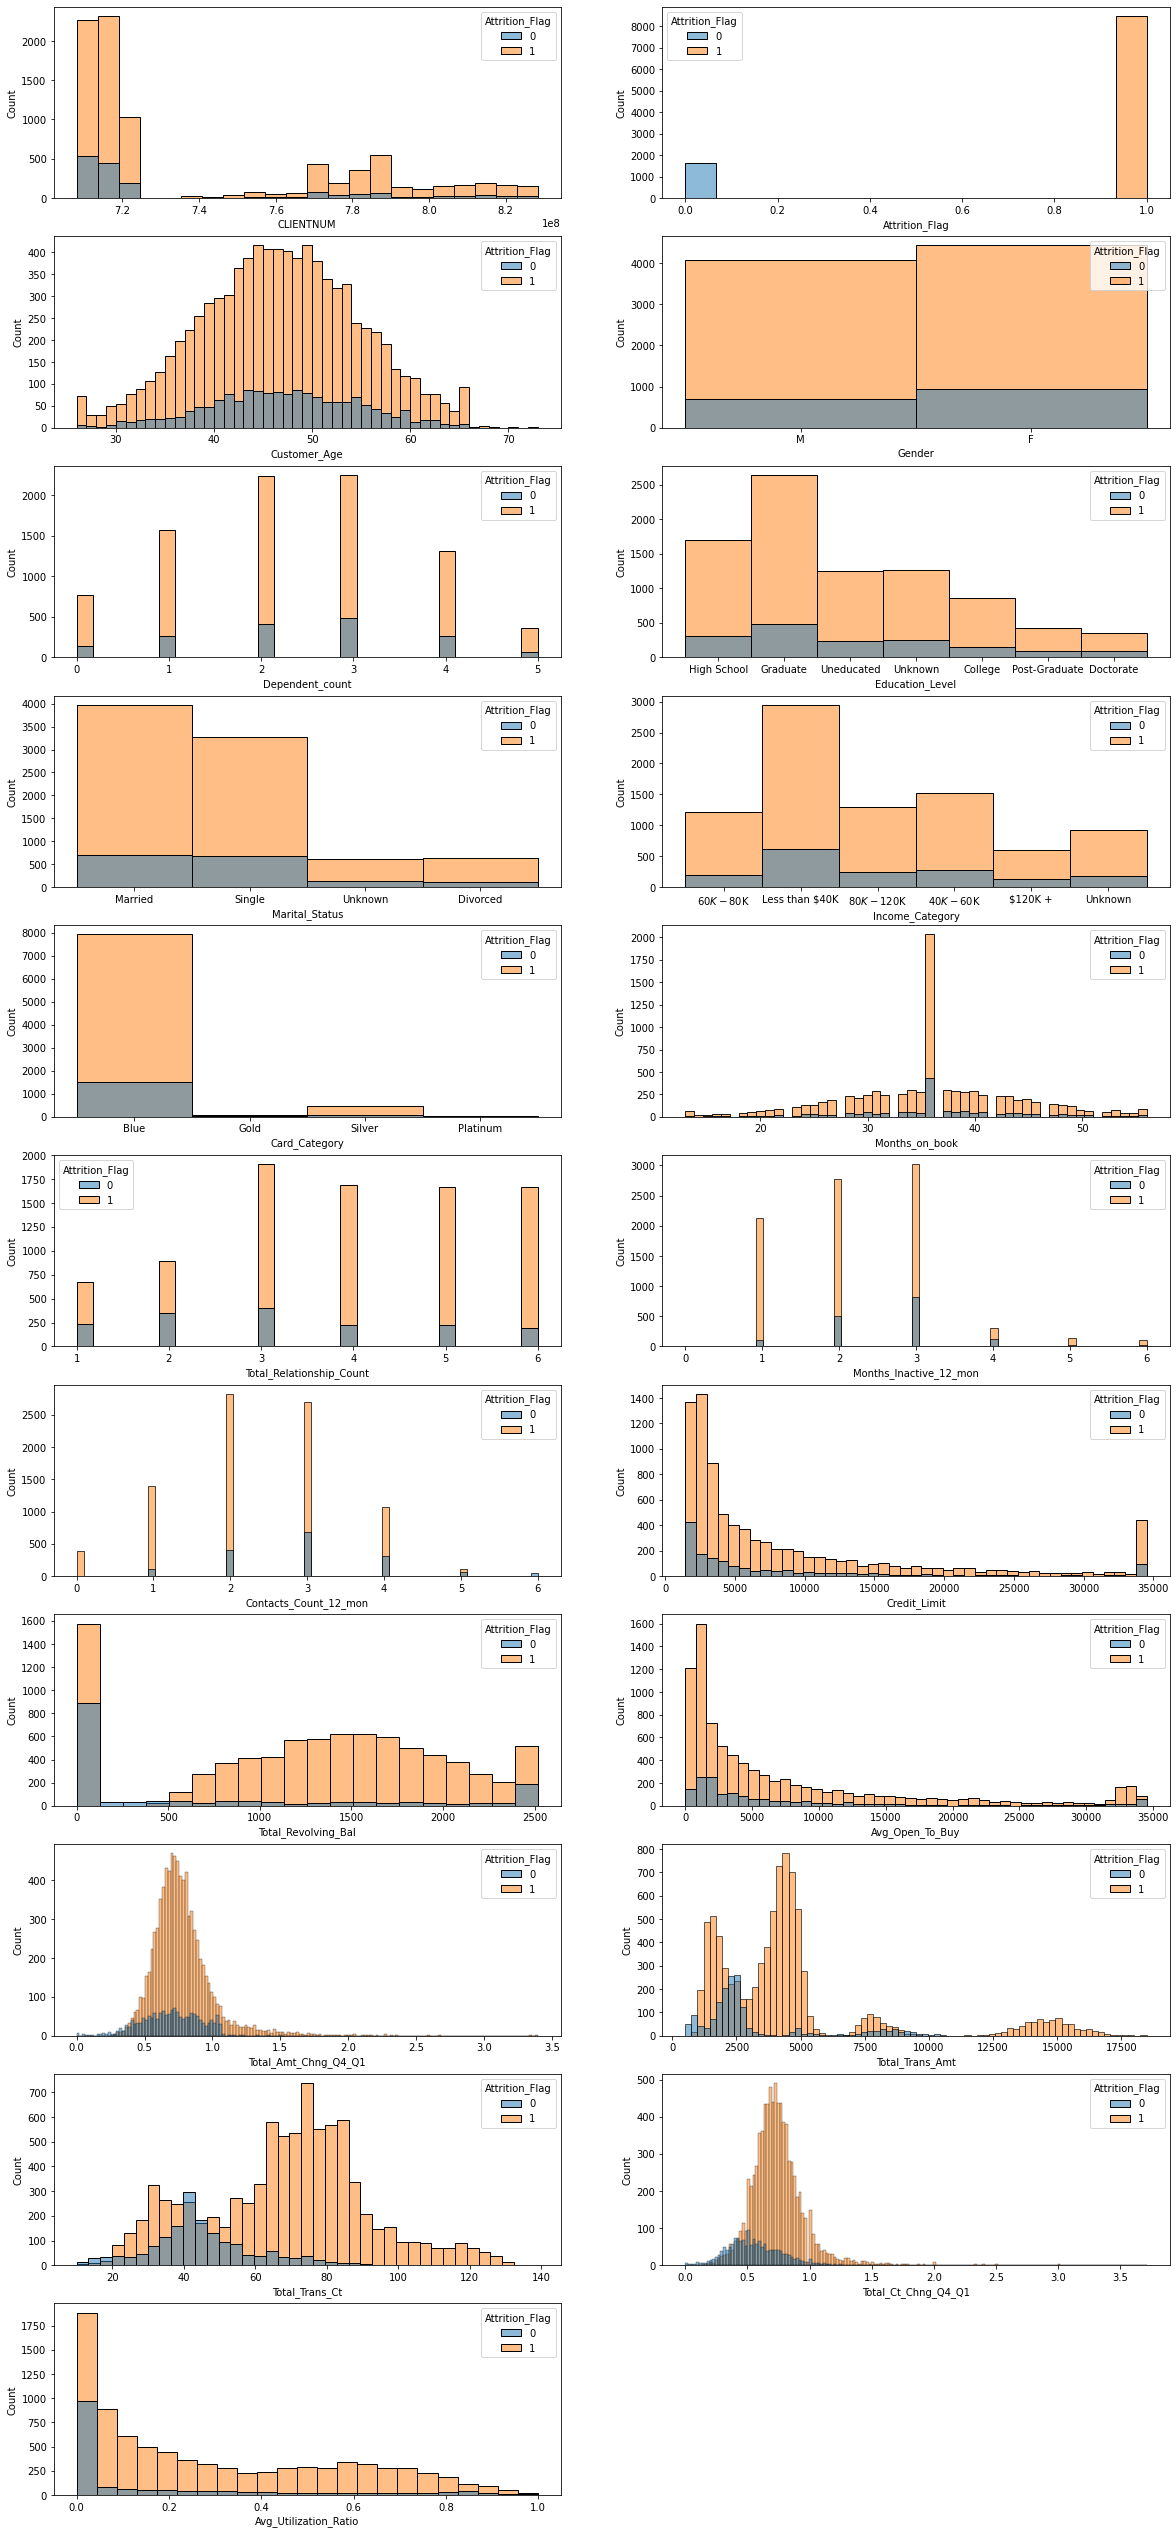

In [45]:
# bins_number = data["Attrition_Flag"].unique().shape[0]
# Le = LabelEncoder()
# y = Le.fit_transform(data["Attrition_Flag"].values)
# sns.set(rc={'figure.figsize':(11.7,12)})
plt.figure(figsize=((20, 50)))
figures_numb_in_row = 2
for idx, feature in enumerate(data):
    if(idx < 21):
        
        plt.subplot(data.shape[1] // figures_numb_in_row + (0 if(data.shape[1] % figures_numb_in_row == 0) else 1), 
                    figures_numb_in_row, idx + 1)
        sns.histplot(x=feature,
                     data=data[[feature, "Attrition_Flag"] if feature != "Attrition_Flag" else [feature]],
                     color=["blue", "green"], hue="Attrition_Flag")


In [39]:
x = data.drop(["Attrition_Flag"], axis=1).values[0: 1000, :]
trash_features = ["CLIENTNUM", 
                 "Customer_Age", 
                 "Gender", 
                 "Dependent_count", 
                 ""]

In [36]:
# print(data["Attrition_Flag"].values)
data["Education_Level"].unique()

array(['High School', 'Graduate', 'Uneducated', 'Unknown', 'College',
       'Post-Graduate', 'Doctorate'], dtype=object)

In [66]:
# x_set, y_set = get_unique(x, y)
data.columns[21]

'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1'

d:\onedrive\pythonpr\samsung_knu_2021_practice\2021-knu-churn\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: If using all scalar values, you must pass an index

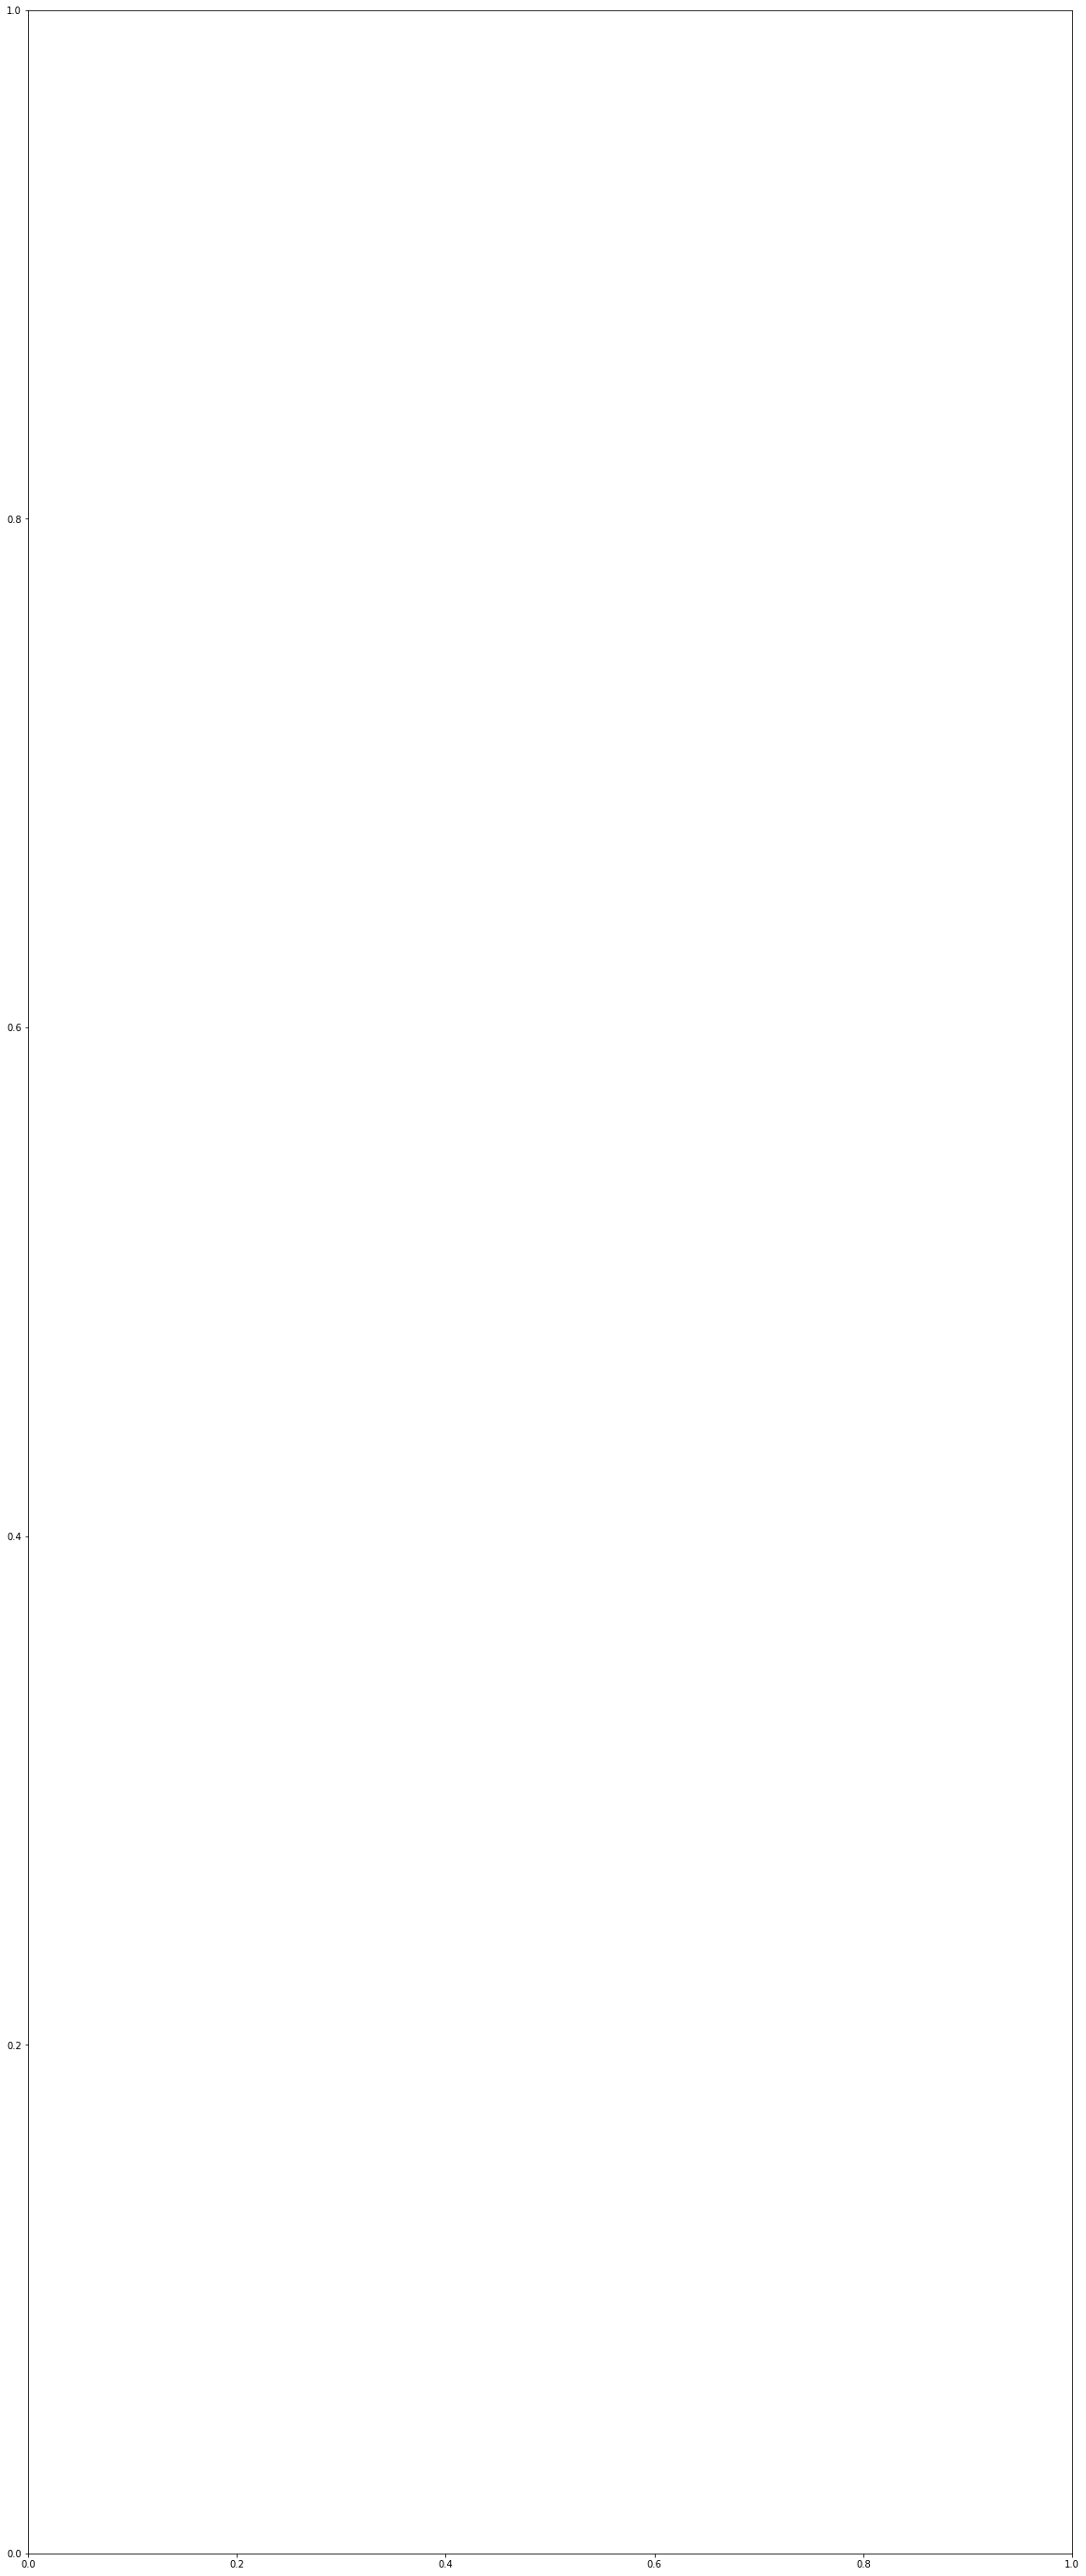

In [67]:
plt.figure(figsize=((20, 50)))
plt.subplot(1, 1, 1)
sns.scatterplot(data[["Attrition_Flag", *data.columns[21: 23]]], x=data.columns[21], color="blue")

In [28]:
y_set.shape


(10127, 1)